<h1>Imports + Data</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from lexicalrichness import LexicalRichness
from sklearn.feature_extraction.text import CountVectorizer # LDA
from sklearn.decomposition import LatentDirichletAllocation # LDA
from sklearn.feature_extraction.text import TfidfVectorizer # NFM TD-IDF
from sklearn.decomposition import NMF #NFM TD-IDF
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from datetime import datetime
from prettytable import PrettyTable

In [2]:
reviews_file_main = pd.read_csv('c:\\Users\\Khider\\Desktop\\Work Uni\\3rd year\\fyp\\datasets\\reviews2.csv', delimiter = ',') #not date ordered
reviews_file_main2 = pd.read_csv('c:\\Users\\Khider\\Desktop\\Work Uni\\3rd year\\fyp\\datasets\\reviews3.csv', delimiter = ',') #date ordered review files

print(type(reviews_file_main['comments']))

def get_reviews(segment):

    reviews_file = reviews_file_main.head(segment) 
    reviews_file.dropna()  #dropping empty cells
    
    return reviews_file

def get_reviews2(segment):

    reviews_file2 = reviews_file_main2.head(segment) 
    reviews_file2.dropna()  #dropping empty cells
    
    return reviews_file2


<class 'pandas.core.series.Series'>


<h3>TTR Analysis</h3>

In [3]:
def calculate_ttr(iterations):
    
    for i in iterations: #iterates depending on what parameter is when function is called
        reviews_file = get_reviews(i)
        lex = LexicalRichness(" ".join([str(comments) for comments in list(reviews_file['comments'])])) #joins an empty space between each entry in "comments", making it one big sentence
        # therefore making it easy to figure out the lexicalrichness of this 
        
        print("Number of reviews from top: ", i)
        print("Word count: ",lex.words)
        print("Unique terms: ",lex.terms)
        print("TTR: ",lex.ttr)
        print("")

    
calculate_ttr([20, 200, 2000, 20000, 200000, 1000000]) 


Number of reviews from top:  20
Word count:  996
Unique terms:  366
TTR:  0.3674698795180723

Number of reviews from top:  200
Word count:  13892
Unique terms:  2417
TTR:  0.17398502735387272

Number of reviews from top:  2000
Word count:  116522
Unique terms:  9236
TTR:  0.0792640016477575

Number of reviews from top:  20000
Word count:  1151465
Unique terms:  32038
TTR:  0.02782368547893336

Number of reviews from top:  200000
Word count:  11229953
Unique terms:  123921
TTR:  0.011034863636561969

Number of reviews from top:  1000000
Word count:  44906192
Unique terms:  291917
TTR:  0.0065005957307624745



<h3> NMF / Non-Negative Matrix Factorization </h3>

In [42]:
def nmf(to_transform):
    topic_table = PrettyTable() #creating a prettytable
    topic_table.field_names = ['id', 'Words']
    
    tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english') #Statistical technique to determine how important a word is to a document, checks to see how frequently it is used. 
    #convert a collection of raw documents to a matrix of TF-IDF(term frequency-inverse document frequency) features, training dataframe                                                             
    doc_term_matrix = tfidf_vect.fit_transform(to_transform) #learn vocabulary and idf, return document term matrix,

    #print(tfidf_vect.get_feature_names())

    nmf = NMF(n_components=5, random_state=40)#5 topics, seed set to 40
    nmf.fit(doc_term_matrix ) #learn vocabulary and idf from training set

    for i,topic in enumerate(nmf.components_): #create a for loop for how many topics there are
        topic_table.add_row(["Topic " + str(i), [tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]]])#gets output feature names and gets only top 10 topics 
        #the top topics have the highest coefficient values in the matrix
    return topic_table
        
reviews_file = get_reviews(20000) #gets the first 20,000 reviews
unordered_nmf = nmf(reviews_file['comments'].values.astype('U')) #converts the the data to unicode
print(unordered_nmf)

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


+---------+-----------------------------------------------------------------------------------------------------------------+
|    id   |                                                      Words                                                      |
+---------+-----------------------------------------------------------------------------------------------------------------+
| Topic 0 |       ['clean', 'perfect', 'room', 'home', 'apartment', 'comfortable', 'lovely', 'flat', 'stay', 'london']      |
| Topic 1 | ['definitely', 'recommend', 'communication', 'flat', 'apartment', 'stay', 'place', 'host', 'location', 'great'] |
| Topic 2 |        ['19', '14', 'day', 'host', 'days', 'arrival', 'automated', 'posting', 'reservation', 'canceled']        |
| Topic 3 |            ['friendly', 'host', 'house', 'room', 'stay', 'clean', 'really', 'good', 'place', 'nice']            |
| Topic 4 |                 ['une', 'pour', 'appartement', 'bien', 'le', 'nous', 'la', 'est', 'très', 'et']           

<h3>LDA / Latent Dirichlet Allocation</h3>

In [7]:
def lda(to_transform):
    
    topic_table = PrettyTable() #creating a prettytable
    topic_table.field_names = ['id', 'Words']

    #CountVectorizer converts a collection of text documents to a matrix of token counts
    count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english') #max_df removes words that show up in 80% of documents, min_df is opposite.
    doc_term_matrix = count_vect.fit_transform(to_transform) #fit transform learns the vocabulary dictionary and returns document-term matrix


    LDA = LatentDirichletAllocation(n_components=5, random_state=40) #n_components means number of topics, #random_state allows for reproducible results, kind of like setting a seed
    LDA.fit(doc_term_matrix) #train the model for the data with variational bayes method

    for i,topic in enumerate(LDA.components_): #create a for loop of the length of however many topics decided on.
        topic_table.add_row(["Topic " + str(i), [count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]]])
    print(topic_table)

reviews_file = get_reviews(20000)  #gets the first 20,000 reviews
lda(reviews_file['comments'].values.astype('U')) #numpy converts the data to unicode

+---------+------------------------------------------------------------------------------------------------+
|    id   |                                             Words                                              |
+---------+------------------------------------------------------------------------------------------------+
| Topic 0 | ['good', 'flat', 'location', 'clean', 'london', 'host', 'great', 'place', 'apartment', 'stay'] |
| Topic 1 |          ['der', 'war', 'jessie', 'wir', 'ist', 'sehr', 'meg', 'die', 'boat', 'und']           |
| Topic 2 |     ['stay', 'robert', 'family', 'airbnb', 'time', 'day', 'tina', 'room', 'home', 'house']     |
| Topic 3 |             ['pour', 'muy', 'bien', 'nous', 'le', 'est', 'en', 'très', 'et', 'la']             |
| Topic 4 |  ['lovely', 'host', 'flat', 'nice', 'clean', 'location', 'place', 'london', 'stay', 'great']   |
+---------+------------------------------------------------------------------------------------------------+


<h3>Testing - Word Frequency</h3>

[('great', 10027), ('stay', 9952), ('london', 8592), ('place', 7404), ('location', 6122), ('host', 5526), ('clean', 5408), ('apartment', 5226), ('flat', 5172), ('nice', 5089)]


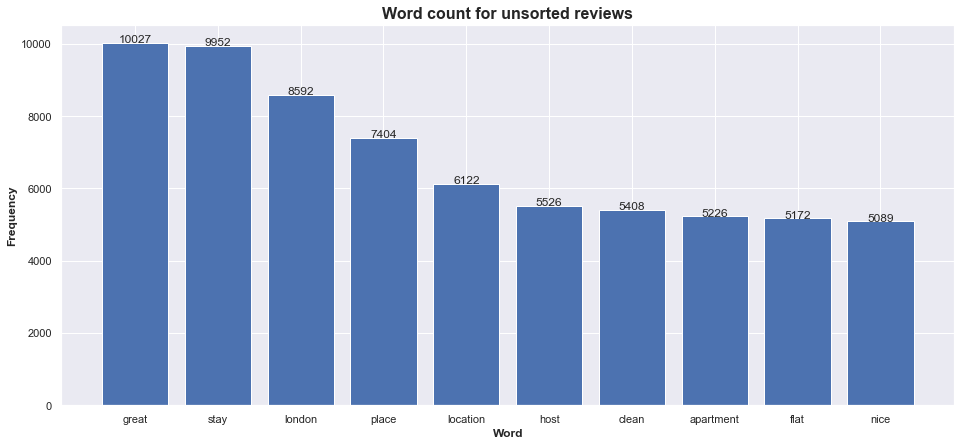

In [26]:
def find_wf(example_sent):
    
    reviews_file = get_reviews(example_sent[0]) #gets top 20,000 reviews
    from_reviews = " ".join([str(comments) for comments in list(reviews_file['comments'])])#joins all the entries in "comments" to essentially make one large string
        
    tokenizer = RegexpTokenizer(r'\w+') #tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.
    result_tokens = tokenizer.tokenize(from_reviews) #tokenize the large string of reviews
    stop_words = set(stopwords.words('english')) #only use english words
    rejoin = " ".join(result_tokens) #add a space between every token
    word_tokens = word_tokenize(rejoin.lower()) #lowercase tokens

    #iterate through and add tokens that are not stopwords into a list, then put in ascending order.
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    freq = list(dict(Counter(filtered_sentence)).items()) #makes a list, which keys/values, which are the word, and the frequency that it is
    sorted_freq = sorted(freq, reverse = True, key = lambda x: x[1])#sorted in descending order, sorted by the value

    #getting the 10 most frequenlty used words and how often they were used
    words = [word[0] for word in sorted_freq][0:10]
    frequency = [freq[1] for freq in sorted_freq][0:10]
    print(sorted_freq[0:10])
    
    #using matplotlib, plyplot is mainly intended for interactive plots and simple cases of programmatic plot generation
    plt.figure(figsize=(16,7))
    plt.bar(words, frequency)
    plt.xlabel('Word', fontsize=12, fontweight="bold")
    plt.ylabel('Frequency', fontsize=12, fontweight="bold")
    plt.title('Word count for unsorted reviews', fontsize = 16, fontweight="bold")
    for a,b in zip(words, frequency):
        plt.text(a, b, str(b), horizontalalignment='center')
    plt.show()

find_wf([20000])

<h1>Dates position and Cumulative TTR Analysis per year</h2>

In [9]:
date_positioning = [1, 109, 971, 4726, 16576, 41759, 94113, 193246, 339493, 547621] #2009-18, this is the entry number in the data where a new year starts

def calculate_ttr2(years):
    
    counter = 2008

    for i in years: #iterates depending on what parameter is when function is called
        reviews_file = get_reviews2(i)
        lex = LexicalRichness(" ".join([str(comments) for comments in list(reviews_file['comments'])])) #joins an empty space between each entry in "comments", making it one big sentence
        # therefore making it easy to figure out the lexicalrichness of this 

        counter += 1
        
        print("Cumulative Review Data from", counter)
        print("Word count: ",lex.words)
        print("Unique terms: ",lex.terms)
        print("TTR: ",lex.ttr)
        print("")
    
calculate_ttr2(date_positioning) 


Cumulative Review Data from 2009
Word count:  35
Unique terms:  30
TTR:  0.8571428571428571

Cumulative Review Data from 2010
Word count:  7878
Unique terms:  1418
TTR:  0.17999492256917998

Cumulative Review Data from 2011
Word count:  70506
Unique terms:  5090
TTR:  0.07219243752304769

Cumulative Review Data from 2012
Word count:  338857
Unique terms:  13142
TTR:  0.038783321578128825

Cumulative Review Data from 2013
Word count:  1191823
Unique terms:  27745
TTR:  0.023279463477378772

Cumulative Review Data from 2014
Word count:  2967504
Unique terms:  50231
TTR:  0.016927020148919766

Cumulative Review Data from 2015
Word count:  6410254
Unique terms:  83060
TTR:  0.012957364871969192

Cumulative Review Data from 2016
Word count:  12063030
Unique terms:  121234
TTR:  0.01005004546950476

Cumulative Review Data from 2017
Word count:  18750952
Unique terms:  164347
TTR:  0.008764728318860824

Cumulative Review Data from 2018
Word count:  27500204
Unique terms:  215051
TTR:  0.00781

<h3>Date Sorted</h3>

In [28]:
#get only the dates and reviews from the data and couple them, then sort them in acsending order
coupled = [(date, review) for date, review in zip(list(reviews_file_main['date']), list(reviews_file_main['comments']))]
coupled_sorted = sorted(coupled, reverse = False, key = lambda x: x[0]) #sorted by date (key shows which value it is sorted by)

#from the sorted data, get only the reviews, also get all the years 
just_reviews_series = pd.Series([review[1] for review in coupled_sorted])
traversed_dates = [datetime(year, 1, 1) for year in range(2010,2020)] #used to turn into matplotlib dates
print(traversed_dates)

[datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2012, 1, 1, 0, 0), datetime.datetime(2013, 1, 1, 0, 0), datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2019, 1, 1, 0, 0)]


<h3>Cumulative TTR analysis into graphs</h3>

[14610. 14975. 15340. 15706. 16071. 16436. 16801. 17167. 17532. 17897.]


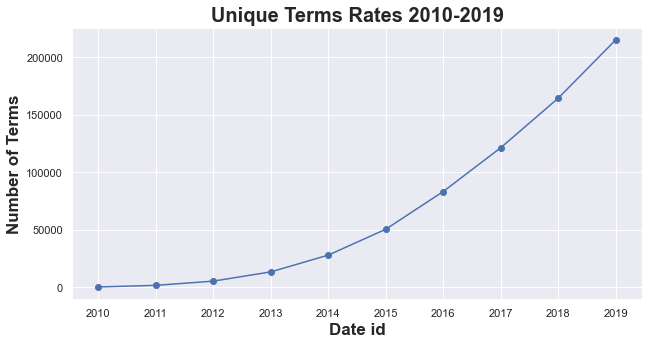

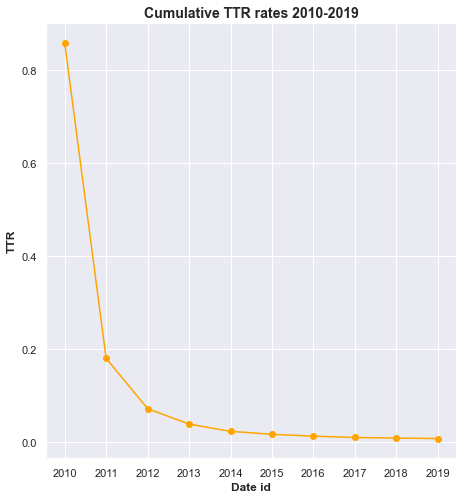

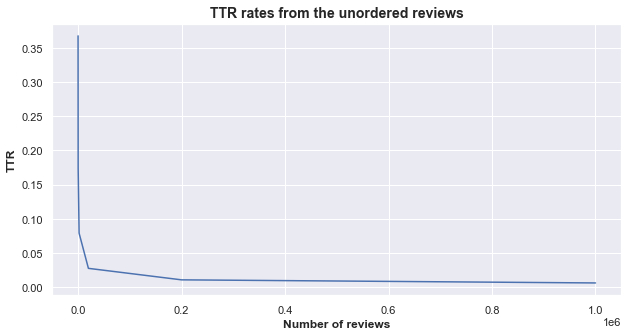

In [29]:
def calculate_ttr(segments):
    #TTR from each years reviews
    ttr_values_yearly = [
                    0.8571428571428571, 0.17999492256917998, #ttr values per year
                    0.07219243752304769, 0.038783321578128825, 
                    0.023279463477378772, 0.016927020148919766,
                    0.012957364871969192, 0.01005004546950476,
                    0.008764728318860824, 0.007819978353615122
                   ]
    #TTR values from the first 20, 200, 2000, 20000, 200000, 1000000 reviews, not date sorted               
    ttr_values_no_date = [
                          0.3674698795180723, 0.17398502735387272, #ttr values from no dates
                          0.0792640016477575,0.02782368547893336, 
                          0.011034863636561969, 0.0065005957307624745  
                         ]

    unique_terms = [30, 1418, 5090, 13142, 27745, 50231, 83060, 121234, 164347, 215051] #unique terms for each year

    #converts datetime objects to matplotlib dates             
    my_dates = dates.date2num(traversed_dates)
    print(my_dates)

    unordered = [20, 200, 2000, 20000, 200000, 1000000]
    plt.figure(figsize=(10.2,5))
    plt.xlabel('Date id', fontsize=17, fontweight="bold")
    plt.ylabel('Number of Terms', fontsize=17, fontweight="bold")
    plt.title('Unique Terms Rates 2010-2019', fontsize=20, fontweight="bold")
    plt.plot_date(my_dates, unique_terms, ls = "solid")
    
    #create a matplotlib graph for TTR over the years
    plt.figure(figsize=(25,8))
    plt.subplot(1, 3, 1)
    plt.xlabel('Date id', fontsize=12, fontweight = 'bold')
    plt.ylabel('TTR', fontsize=12, fontweight = 'bold')
    plt.title('Cumulative TTR rates 2010-2019', fontsize=14, fontweight="bold")
    plt.plot_date(my_dates, ttr_values_yearly, ls = "solid", color = "orange")

    plt.figure(figsize=(10.2,5))
    plt.xlabel('Number of reviews', fontsize=12, fontweight = 'bold')
    plt.ylabel('TTR', fontsize=12, fontweight = 'bold')
    plt.title('TTR rates from the unordered reviews', fontsize=14, fontweight="bold")
    plt.plot(unordered, ttr_values_no_date, ls = "solid")
    
calculate_ttr(date_positioning)

<h3>Non Cumulative Yearly TTR Analysis</h3>

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2011
+---------+--------------------------------------------------------------------------------------------------------------------+
|    id   |                                                       Words                                                        |
+---------+--------------------------------------------------------------------------------------------------------------------+
| Topic 0 |            ['perfect', 'street', 'location', 'tube', 'host', 'station', 'walk', 'good', 'stay', 'flat']            |
| Topic 1 |               ['bien', 'le', 'londres', 'séjour', 'nous', 'appartement', 'est', 'la', 'et', 'très']                |
| Topic 2 | ['need', 'transportation', 'day', 'available', 'neighborhood', 'helpful', 'close', 'great', 'london', 'apartment'] |
| Topic 3 |         ['underground', 'breakfast', 'time', 'stay', 'clean', 'london', 'room', 'place', 'nice', 'really']         |
| Topic 4 |        ['days', 'wonderful', 'helped', 'homely', 'welcome'

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2012
+---------+-----------------------------------------------------------------------------------------------------------------+
|    id   |                                                      Words                                                      |
+---------+-----------------------------------------------------------------------------------------------------------------+
| Topic 0 |      ['recommend', 'friendly', 'stay', 'comfortable', 'really', 'clean', 'room', 'house', 'place', 'nice']      |
| Topic 1 |                  ['en', 'pour', 'bien', 'la', 'appartement', 'le', 'nous', 'est', 'très', 'et']                 |
| Topic 2 | ['london', 'welcoming', 'guy', 'price', 'helpful', 'communication', 'location', 'experience', 'really', 'good'] |
| Topic 3 |   ['definitely', 'highly', 'place', 'helpful', 'stay', 'recommend', 'apartment', 'host', 'location', 'great']   |
| Topic 4 |        ['central', 'easy', 'walk', 'located', 'close', 'perfect', 'stay', 'apar

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2013
+---------+-------------------------------------------------------------------------------------------------------------+
|    id   |                                                    Words                                                    |
+---------+-------------------------------------------------------------------------------------------------------------+
| Topic 0 |    ['house', 'really', 'perfect', 'recommend', 'lovely', 'flat', 'apartment', 'clean', 'stay', 'london']    |
| Topic 1 |             ['logement', 'pour', 'appartement', 'bien', 'le', 'nous', 'la', 'est', 'très', 'et']            |
| Topic 2 |  ['communication', 'space', 'highly', 'lovely', 'recommend', 'host', 'stay', 'place', 'location', 'great']  |
| Topic 3 | ['apartment', 'room', 'price', 'value', 'communication', 'host', 'experience', 'clean', 'location', 'good'] |
| Topic 4 |            ['near', 'close', 'house', 'room', 'host', 'clean', 'stay', 'really', 'place', 'nice']          

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2014
+---------+----------------------------------------------------------------------------------------------------------+
|    id   |                                                  Words                                                   |
+---------+----------------------------------------------------------------------------------------------------------+
| Topic 0 |      ['recommend', 'room', 'flat', 'lovely', 'really', 'london', 'clean', 'place', 'stay', 'nice']       |
| Topic 1 |    ['25', '14', 'day', 'host', 'days', 'arrival', 'reservation', 'canceled', 'automated', 'posting']     |
| Topic 2 | ['highly', 'apartment', 'communication', 'hosts', 'value', 'host', 'stay', 'place', 'location', 'great'] |
| Topic 3 |              ['en', 'pour', 'appartement', 'le', 'nous', 'bien', 'la', 'est', 'très', 'et']              |
| Topic 4 |    ['price', 'nice', 'place', 'room', 'clean', 'communication', 'money', 'value', 'location', 'good']    |
+---------+----------

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2015
+---------+-----------------------------------------------------------------------------------------------------------+
|    id   |                                                   Words                                                   |
+---------+-----------------------------------------------------------------------------------------------------------+
| Topic 0 | ['apartment', 'perfect', 'room', 'comfortable', 'recommend', 'flat', 'clean', 'london', 'lovely', 'stay'] |
| Topic 1 |   ['space', 'flat', 'value', 'communication', 'apartment', 'place', 'stay', 'host', 'location', 'great']  |
| Topic 2 |     ['19', '28', 'day', 'host', 'days', 'arrival', 'reservation', 'posting', 'canceled', 'automated']     |
| Topic 3 |   ['friendly', 'clean', 'room', 'host', 'price', 'money', 'communication', 'value', 'location', 'good']   |
| Topic 4 |         ['quiet', 'area', 'recommend', 'room', 'host', 'clean', 'really', 'stay', 'place', 'nice']        |
+---------+--

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2016
+---------+-------------------------------------------------------------------------------------------------------------+
|    id   |                                                    Words                                                    |
+---------+-------------------------------------------------------------------------------------------------------------+
| Topic 0 |  ['perfect', 'room', 'apartment', 'comfortable', 'recommend', 'flat', 'clean', 'lovely', 'london', 'stay']  |
| Topic 1 | ['recommend', 'hosts', 'communication', 'apartment', 'value', 'stay', 'host', 'place', 'location', 'great'] |
| Topic 2 |      ['23', '26', 'day', 'host', 'days', 'arrival', 'reservation', 'automated', 'posting', 'canceled']      |
| Topic 3 |   ['experience', 'host', 'price', 'room', 'clean', 'money', 'communication', 'value', 'location', 'good']   |
| Topic 4 |            ['cosy', 'quiet', 'cozy', 'room', 'host', 'clean', 'really', 'stay', 'place', 'nice']           

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2017
+---------+-------------------------------------------------------------------------------------------------------------+
|    id   |                                                    Words                                                    |
+---------+-------------------------------------------------------------------------------------------------------------+
| Topic 0 |  ['perfect', 'recommend', 'room', 'apartment', 'comfortable', 'flat', 'clean', 'london', 'lovely', 'stay']  |
| Topic 1 |      ['18', '11', 'day', 'host', 'days', 'arrival', 'reservation', 'canceled', 'posting', 'automated']      |
| Topic 2 | ['hosts', 'recommend', 'apartment', 'communication', 'value', 'stay', 'host', 'place', 'location', 'great'] |
| Topic 3 |    ['apartment', 'host', 'price', 'room', 'communication', 'clean', 'money', 'value', 'location', 'good']   |
| Topic 4 |         ['area', 'people', 'recommend', 'room', 'host', 'clean', 'really', 'stay', 'place', 'nice']        

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2018
+---------+-----------------------------------------------------------------------------------------------------------+
|    id   |                                                   Words                                                   |
+---------+-----------------------------------------------------------------------------------------------------------+
| Topic 0 | ['perfect', 'apartment', 'recommend', 'comfortable', 'flat', 'room', 'london', 'clean', 'lovely', 'stay'] |
| Topic 1 |   ['space', 'flat', 'apartment', 'communication', 'value', 'stay', 'place', 'host', 'location', 'great']  |
| Topic 2 |     ['14', '13', 'day', 'host', 'days', 'arrival', 'reservation', 'posting', 'automated', 'canceled']     |
| Topic 3 |    ['really', 'host', 'price', 'room', 'clean', 'communication', 'money', 'value', 'location', 'good']    |
| Topic 4 |        ['cozy', 'quiet', 'people', 'recommend', 'host', 'clean', 'really', 'stay', 'place', 'nice']       |
+---------+--

c:\Users\Khider\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topics for reviews in 2019
+---------+-----------------------------------------------------------------------------------------------------------+
|    id   |                                                   Words                                                   |
+---------+-----------------------------------------------------------------------------------------------------------+
| Topic 0 | ['perfect', 'apartment', 'recommend', 'comfortable', 'flat', 'room', 'london', 'clean', 'stay', 'lovely'] |
| Topic 1 |  ['space', 'hosts', 'apartment', 'communication', 'value', 'stay', 'place', 'host', 'location', 'great']  |
| Topic 2 |     ['13', '12', 'day', 'host', 'days', 'arrival', 'reservation', 'posting', 'automated', 'canceled']     |
| Topic 3 |   ['excellent', 'host', 'price', 'room', 'clean', 'money', 'communication', 'value', 'location', 'good']  |
| Topic 4 |        ['quiet', 'cozy', 'people', 'host', 'recommend', 'clean', 'really', 'stay', 'place', 'nice']       |
+---------+--

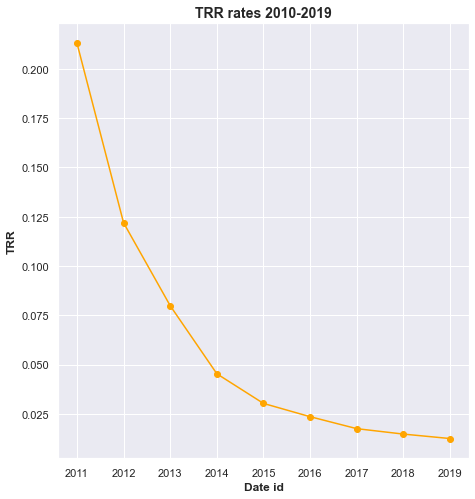

In [34]:
def get_just_reviews_yearly(segment):
    reviews_file1 = just_reviews_series[segment[1]:segment[0]] #referenced later, used to segment each year
    return reviews_file1

def calculate_ttr_yearly(segments): #called just like the cumulative ttr, except there is spliced values
    unique_terms = []
    ttr_values = []
    sliced_values=[0,0]
    year_counter = 2011
    x = PrettyTable()
    x.field_names = ['year', 'Number of Reviews', 'Number of Words', 'Unique Terms', 'TTR']
    start = 2010

    #loops for each year
    for counter, current in enumerate(segments): #segments is when each year starts, look at when this function is called
        if counter != 0:
            sliced_values[0] = current
            sliced_values[1] = segments[counter - 1] 
            reviews_file1 = get_just_reviews_yearly(sliced_values) #gets reviews in that year and not including years before
            lex = LexicalRichness(" ".join([str(comments) for comments in list(reviews_file1)]))
            lex_terms = lex.terms
            unique_terms.append(lex_terms)
            
            #perform a topic model on this years review as well
            just_reviews_series = pd.Series(reviews_file1)
            topic_table = nmf(just_reviews_series.values.astype('U')) #nmf returns topic table
            print("Topics for reviews in", year_counter)
            print(topic_table)
            year_counter+=1
            lex_ttr = lex.ttr
            ttr_values.append(lex_ttr) #add each years TTR values to this variable, used in the plot later
            
            #row starts with year, then reviews in that year, then the amount of words, unique terms and the ttr.
            x.add_row([start + counter, current-segments[counter-1], lex.words, lex_terms, lex_ttr])                
    print(x) #print PrettyTable

    #create a matplotlib graph for TTR over the years
    my_dates = dates.date2num(traversed_dates)
    plt.figure(figsize=(25,8))
    plt.subplot(1, 3, 1)
    plt.xlabel('Date id', fontsize=12, fontweight = 'bold')
    plt.ylabel('TRR', fontsize=12, fontweight = 'bold')
    plt.title('TRR rates 2010-2019', fontsize=14, fontweight="bold")
    plt.plot_date(my_dates[1:], ttr_values, ls = "solid", color = "orange")

calculate_ttr_yearly(date_positioning) #this parameter is used as it shows what position each year starts at

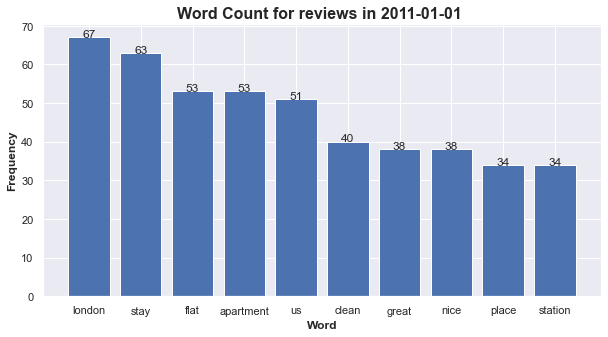

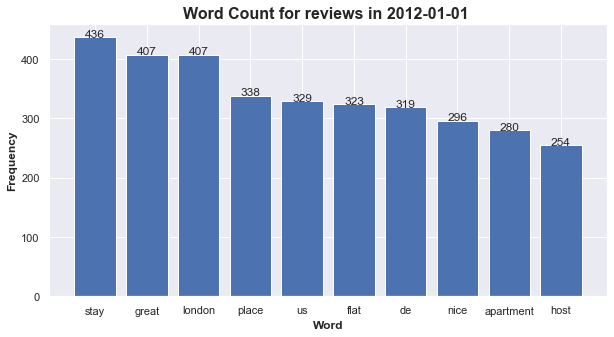

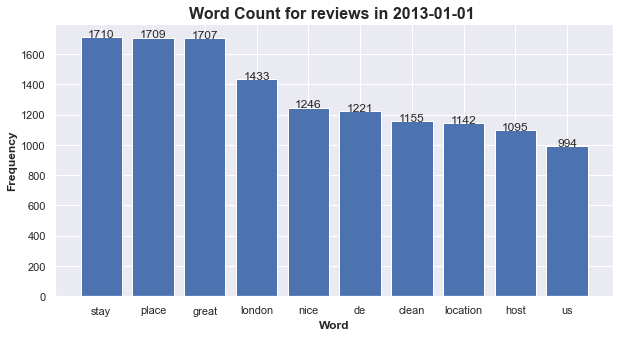

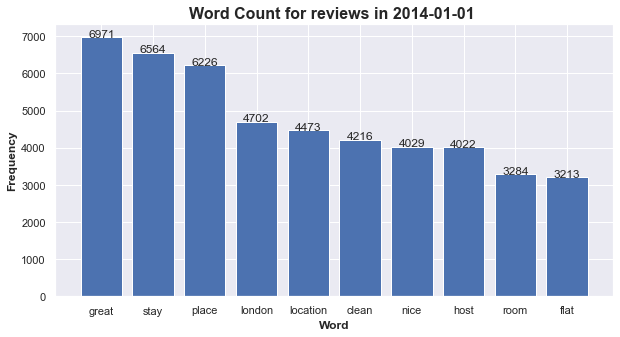

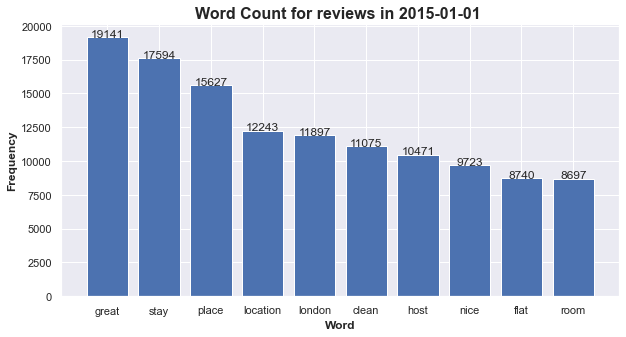

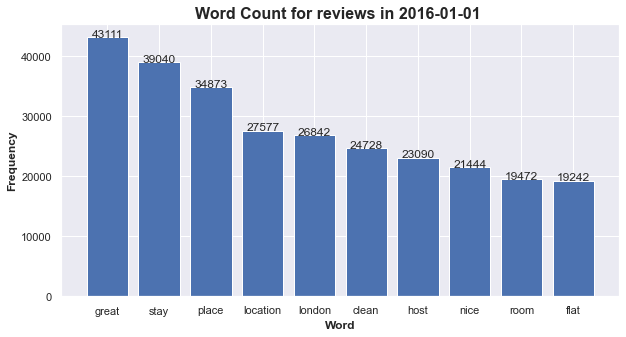

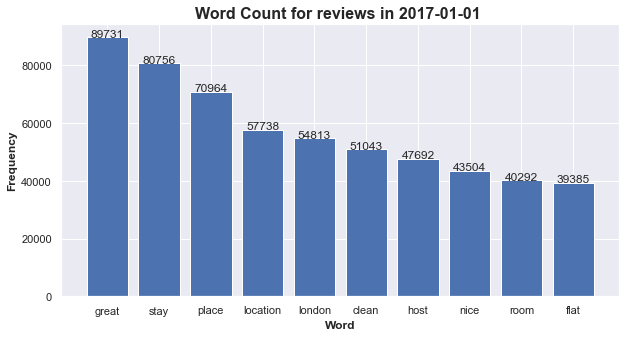

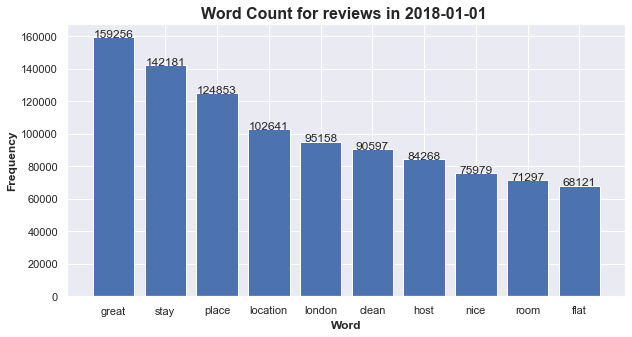

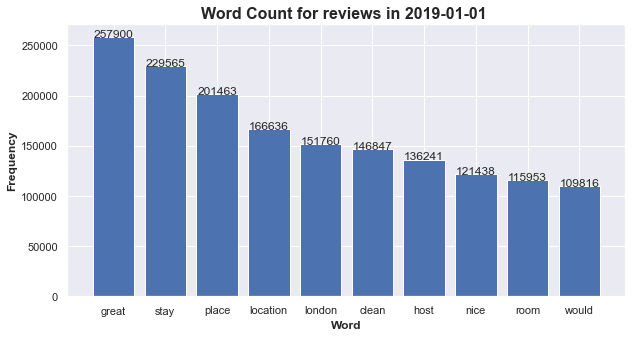

In [40]:
def get_just_reviews(segment):

    reviews_file = just_reviews_series.head(segment) #get only reviews
    reviews_file.dropna()
    
    return reviews_file

def find_wf(example_sent):
    
    
    for i, position in enumerate(example_sent): #iterates through each year, by using the date_positioning array
        reviews_file = get_just_reviews(position)
        from_reviews = " ".join([str(comments) for comments in list(reviews_file)]) #add all the reviews in that year to one string

        #tokenize, remove non english words, and lower case these words in this string.
        tokenizer = RegexpTokenizer(r'\w+')
        result_tokens = tokenizer.tokenize(from_reviews)
        stop_words = set(stopwords.words('english'))
        rejoin = " ".join(result_tokens)
        word_tokens = word_tokenize(rejoin.lower()) 

        #iterate through and add tokens that are not stopwords into a list, then put in ascending order.
        filtered_sentence = [w for w in word_tokens if not w in stop_words] #remove stop words
        freq = list(dict(Counter(filtered_sentence)).items())
        sorted_freq = sorted(freq, reverse = True, key = lambda x: x[1])

        #getting the 10 most frequenlty used words and how often they were used
        words = [word[0] for word in sorted_freq][0:10]
        frequency = [freq[1] for freq in sorted_freq][0:10]
    
        #create a matplotlib bar chart
        plt.figure(figsize=(10,5))
        plt.bar(words, frequency)
        plt.xlabel('Word', fontsize=12, fontweight="bold")
        plt.ylabel('Frequency', fontsize=12, fontweight="bold")
        plt.title('Word Count for reviews in ' + str(traversed_dates[i+1])[0:11], fontsize = 16, fontweight="bold")
        for a,b in zip(words, frequency):
            plt.text(a, b, str(b), horizontalalignment='center')
        plt.show()

find_wf(date_positioning[1:]) #does not include the last 2 values of the array